<a href="https://colab.research.google.com/github/MarcosVCS/Projeto-Final---Engenharia-de-Dados---SoulCode/blob/main/ETL_Pre%C3%A7o_combust%C3%ADveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [ ]:
#instalar biblioteca da google cloud storage file system
!pip install gcsfs
!pip install pyspark

In [ ]:
import pandas as pd
import numpy as np

from google.cloud import storage
from google.oauth2 import service_account 
import os
import pandas_gbq 

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from IPython.display import clear_output

In [ ]:
# ACESSO À BUCKET COM DATASETS BRUTOS

# FAZER O ACESSO A BUCKET
serviceAccount = '/content/chave_bucket_JSON.json' # Chave de acesso à Bucket no Cloud Storage
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount
client = storage.Client()             

# CRIAR UMA VARIÁVEL PARA RECEBER O NOME DA BUCKET 
bucket = client.get_bucket('bc26-datasets-comex')

In [ ]:
# SETUP DISPLAY PANDAS
pd.set_option('display.max_columns', 100)

#Leitura dos dataframes originais

In [ ]:
# Ler o arquivo vindo da Bucket (Pandas)

# Observação: optou-se por importar o arquivo utilizando Pandas
# Dados, após agrupamento, serão tratados com PySpark.

# Dados de 2013 a 2017
df1 = pd.read_excel('gs://bc26-datasets-comex/combustível_semanal_xlsx/semanal-municipios-2013-a-2017.xlsx', skiprows=14)

# Dados de 2018 a 2021
df2 = pd.read_excel('gs://bc26-datasets-comex/combustível_semanal_xlsx/semanal-municipios-2018-a-2021.xlsx', skiprows=13)

# Dados de 2022
df3 = pd.read_excel('gs://bc26-datasets-comex/combustível_semanal_xlsx/semanal-municipios-2022.xlsx', skiprows=11)

Análise prévia da estrutura dos dataframes originais
> Objetivo: juntá-los em um único dataframe




In [ ]:
# Verificar número de registros em cada dataframe

print(f'Nº registros df1: {df1.shape[0]}')
print(f'Nº registros df2: {df2.shape[0]}')
print(f'Nº registros df3: {df3.shape[0]}')
print(f'Total de registros nos três df: {df1.shape[0] + df2.shape[0]+ df3.shape[0]}')

Nº registros df1: 657872
Nº registros df2: 420481
Nº registros df3: 112567
Total de registros nos três df: 1190920


In [ ]:
# Visualizando se tabelas são compatíveis

# df1.info()
# df2.info()
df3.info()

# DF's 1 e 2 NÃO são compatíveis com DF3 (último dataframe apresenta menos colunas) 
# Necessário remover colunas dos dataframes 1 e 2

In [ ]:
# Drop de colunas para compatibilização

df1.drop(['PREÇO MÉDIO DISTRIBUIÇÃO', 'DESVIO PADRÃO DISTRIBUIÇÃO', 'PREÇO MÍNIMO DISTRIBUIÇÃO', 'PREÇO MÁXIMO DISTRIBUIÇÃO', 'COEF DE VARIAÇÃO DISTRIBUIÇÃO'], axis = 1, inplace = True)
df2.drop(['PREÇO MÉDIO DISTRIBUIÇÃO', 'DESVIO PADRÃO DISTRIBUIÇÃO', 'PREÇO MÍNIMO DISTRIBUIÇÃO', 'PREÇO MÁXIMO DISTRIBUIÇÃO', 'COEF DE VARIAÇÃO DISTRIBUIÇÃO'], axis = 1, inplace = True)

In [ ]:
# Consolidando três dataframes em um único

df = pd.concat([df1, df2, df3])
print(f'Nº registros df consolidado: {df.shape[0]}')

Nº registros df consolidado: 1190920


In [ ]:
# Fazer backup do dataframe

df_backup = df.copy()

In [ ]:
# Dropar duplicatas

df = df.drop_duplicates()
print(f'Foram removidas {df_backup.shape[0] - df.shape[0]} duplicatas')

# OBSERVAÇÃO: Não havia registros duplicados

In [ ]:
# Transformação das strings "-" em NaN (necessário para otimização da tabela)

df.replace(['-'], np.NaN, inplace = True)

In [ ]:
# Conversão do dataframe para parquet (ganho de eficiência)

df.to_parquet('preco-combustiveis-2013-2022', index = False)

Envio do dataframe único para Cloud Storage

In [ ]:
# Envio do arquivo em parquet para Cloud Storage

serviceAccount = '/content/chave_bucket_JSON.json' # Chave de acesso à Bucket no Cloud Storage
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

client = storage.Client()             
bucket = client.get_bucket('bc26-datasets-comex')

blob = bucket.blob('preco-combustiveis-2013-2022')
blob.upload_from_filename('/content/preco-combustiveis-2013-2022')

# Análise e tratamento dos dados com PySpark

Conversão do dataframe de Pandas para PySpark

In [ ]:
# Configurar a variável do ambiente Spark

spark = (
    SparkSession.builder
    .master('local')
    .appName('tratamento_combustiveis')
    .config('spark.ui.port', '4050')
    .config('spark.jars', 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
    .getOrCreate()
)

In [ ]:
# Preparar schema para importar dataframe (StructTypes)

esquema = (
    StructType([
        StructField('data_inicial', DateType()),
        StructField('data_final', DateType()),
        StructField('regiao', StringType()),
        StructField('estado', StringType()),
        StructField('municipio', StringType()),
        StructField('produto', StringType()),
        StructField('num_postos_pesquisados', IntegerType()),
        StructField('unidade_medida', StringType()),
        StructField('preco_medio_revenda', FloatType()),
        StructField('desvio_padrao_revenda', FloatType()),
        StructField('preco_min_revenda', FloatType()),
        StructField('preco_max_revenda', FloatType()),
        StructField('margem_media_revenda', FloatType()),
        StructField('coef_variacao_revenda', FloatType())
    ])
)

In [ ]:
# Conversão para PySpark (utilizando schema definido - o que renomeará as colunas)

dfs = spark.createDataFrame(df, schema = esquema)

In [ ]:
dfs.show()

+------------+----------+------------+----------------+--------------------+----------------+----------------------+--------------+-------------------+---------------------+-----------------+-----------------+--------------------+---------------------+
|data_inicial|data_final|      regiao|          estado|           municipio|         produto|num_postos_pesquisados|unidade_medida|preco_medio_revenda|desvio_padrao_revenda|preco_min_revenda|preco_max_revenda|margem_media_revenda|coef_variacao_revenda|
+------------+----------+------------+----------------+--------------------+----------------+----------------------+--------------+-------------------+---------------------+-----------------+-----------------+--------------------+---------------------+
|  2012-12-30|2013-01-05|CENTRO OESTE|DISTRITO FEDERAL|            BRASILIA|ETANOL HIDRATADO|                    80|          R$/l|              2.273|          0.022864401|             2.19|            2.299|               0.405|           

In [ ]:
dfs.printSchema()

root
 |-- data_inicial: date (nullable = true)
 |-- data_final: date (nullable = true)
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- produto: string (nullable = true)
 |-- num_postos_pesquisados: integer (nullable = true)
 |-- unidade_medida: string (nullable = true)
 |-- preco_medio_revenda: float (nullable = true)
 |-- desvio_padrao_revenda: float (nullable = true)
 |-- preco_min_revenda: float (nullable = true)
 |-- preco_max_revenda: float (nullable = true)
 |-- margem_media_revenda: float (nullable = true)
 |-- coef_variacao_revenda: float (nullable = true)



In [ ]:
dfs.count()

1190920

In [ ]:
# Criar backup no PySpark

dfs_back = dfs

## Análise dos dados contidos nas colunas e correções pontuais

In [ ]:
dfs.groupBy('regiao').count().orderBy('count').show()

# OK

+------------+------+
|      regiao| count|
+------------+------+
|CENTRO OESTE| 78213|
|       NORTE| 93435|
|         SUL|222533|
|    NORDESTE|253619|
|     SUDESTE|543120|
+------------+------+



In [ ]:
dfs.groupBy('estado').count().orderBy('count').show(30)

# OK

+-------------------+------+
|             estado| count|
+-------------------+------+
|   DISTRITO FEDERAL|  2707|
|            RORAIMA|  4964|
|              AMAPA|  5935|
|               ACRE|  7247|
|              PIAUI| 11731|
|           AMAZONAS| 12056|
|          TOCANTINS| 12283|
|            SERGIPE| 12326|
|RIO GRANDE DO NORTE| 13147|
|            ALAGOAS| 14757|
|           RONDONIA| 15610|
| MATO GROSSO DO SUL| 17878|
|        MATO GROSSO| 17956|
|            PARAIBA| 18696|
|           MARANHAO| 28865|
|     ESPIRITO SANTO| 30270|
|              CEARA| 33951|
|               PARA| 35340|
|              GOIAS| 39672|
|         PERNAMBUCO| 47535|
|     SANTA CATARINA| 56043|
|             PARANA| 70125|
|              BAHIA| 72611|
|     RIO DE JANEIRO| 89430|
|  RIO GRANDE DO SUL| 96365|
|       MINAS GERAIS|142213|
|          SAO PAULO|281207|
+-------------------+------+



In [ ]:
# Análise dos municípios (filtrados por estado)

ordem = 'asc'

lista_UF = ['RIO DE JANEIRO','RIO GRANDE DO SUL','RONDONIA','MATO GROSSO','ESPIRITO SANTO','SERGIPE','AMAZONAS','RIO GRANDE DO NORTE','SANTA CATARINA','PARAIBA','GOIAS','MINAS GERAIS','SAO PAULO','PARANA','ALAGOAS',
'MARANHAO','DISTRITO FEDERAL','PIAUI','ACRE','PARA','MATO GROSSO DO SUL','BAHIA','PERNAMBUCO','CEARA','AMAPA','TOCANTINS','RORAIMA']

for UF in lista_UF:
  df_uf = dfs.filter(F.col('estado') == UF)

  if ordem == 'desc':
    df_uf.groupBy('municipio').count().orderBy(F.col('count').desc()).show(30, truncate = False)
    print(f'UF: {UF}')
    controle = input('aperte enter')
    clear_output(wait = True)
  elif ordem == 'asc':
    df_uf.groupBy('municipio').count().orderBy(F.col('count').asc()).show(30, truncate = False)
    print(f'UF: {UF}')
    controle = input('aperte enter')
    clear_output(wait = True)
  else:
    print('erro ao designar ordem')
    break
  
  # OK
  # OBSERVAÇÃO: Constatou-se que não são todos os municípios do país que estão representados pela pesquisa

In [ ]:
dfs.select('produto').distinct().show(truncate = False)

# INCONSISTÊNCIA: 'OLEO DIESEL S10' | 'ÓLEO DIESEL S10'
# INCONSISTÊNCIA: 'OLEO DIESEL' | 'ÓLEO DIESEL'

+------------------+
|produto           |
+------------------+
|ÓLEO DIESEL       |
|ETANOL HIDRATADO  |
|OLEO DIESEL S10   |
|ÓLEO DIESEL S10   |
|GASOLINA ADITIVADA|
|GASOLINA COMUM    |
|GLP               |
|OLEO DIESEL       |
|GNV               |
+------------------+



In [ ]:
# Alterar dado 'ÓLEO DIESEL S10' para 'OLEO DIESEL S10'
dfs = dfs.withColumn('produto', F.regexp_replace(F.col('produto'), 'ÓLEO DIESEL S10', 'OLEO DIESEL S10'))

# Alterar dado 'ÓLEO DIESEL' para 'OLEO DIESEL'
dfs = dfs.withColumn('produto', F.regexp_replace(F.col('produto'), 'ÓLEO DIESEL', 'OLEO DIESEL'))

In [ ]:
# Verificar se existe dado 'num_postos_pesquisados' igual a zero

dfs.filter(F.col('num_postos_pesquisados') == 0).show(truncate = False)

# OK (não há)

+------------+----------+------+------+---------+-------+----------------------+--------------+-------------------+---------------------+-----------------+-----------------+--------------------+---------------------+
|data_inicial|data_final|regiao|estado|municipio|produto|num_postos_pesquisados|unidade_medida|preco_medio_revenda|desvio_padrao_revenda|preco_min_revenda|preco_max_revenda|margem_media_revenda|coef_variacao_revenda|
+------------+----------+------+------+---------+-------+----------------------+--------------+-------------------+---------------------+-----------------+-----------------+--------------------+---------------------+
+------------+----------+------+------+---------+-------+----------------------+--------------+-------------------+---------------------+-----------------+-----------------+--------------------+---------------------+



In [ ]:
dfs.select('unidade_medida').distinct().show()

# INCONSISTÊNCIA: 'R$/13kg' | 'R$/13Kg'
# INCONSISTÊNCIA: 'R$/m3' | 'R$/m³'

+--------------+
|unidade_medida|
+--------------+
|          R$/l|
|       R$/13kg|
|         R$/m3|
|       R$/13Kg|
|         R$/m³|
+--------------+



In [ ]:
# Alterar dado 'R$/13Kg' para 'R$/13kg'
dfs = dfs.withColumn('unidade_medida', F.regexp_replace(F.col('unidade_medida'), 'R$/13Kg', 'R$/13kg'))

# Alterar dado 'R$/m³' para 'R$/m3'
dfs = dfs.withColumn('unidade_medida', F.regexp_replace(F.col('unidade_medida'), 'R$/m³', 'R$/m3'))

In [ ]:
# Análise das tabelas contendo números tipo float

df_numeros = dfs.select('preco_medio_revenda', 'desvio_padrao_revenda','preco_min_revenda','preco_max_revenda','margem_media_revenda','coef_variacao_revenda')

df_numeros.show()

+-------------------+---------------------+-----------------+-----------------+--------------------+---------------------+
|preco_medio_revenda|desvio_padrao_revenda|preco_min_revenda|preco_max_revenda|margem_media_revenda|coef_variacao_revenda|
+-------------------+---------------------+-----------------+-----------------+--------------------+---------------------+
|              2.273|          0.022864401|             2.19|            2.299|               0.405|                 0.01|
|              2.134|          0.043358967|             2.09|             2.19|               0.268|                 0.02|
|              1.865|          0.054574985|             1.69|            1.899|                0.36|                0.029|
|              1.771|           0.02253203|             1.73|             1.79|               0.206|                0.013|
|              1.918|           0.10539576|             1.65|            1.999|               0.376|                0.055|
|              1

In [ ]:
# OK

# OBSERVAÇÃO: Decidiu-se arredondar os valores apresentados na coluna 'desvio_padrao_revenda'

In [ ]:
#Análise de agregados numéricos

df_numeros.summary().show()

+-------+-------------------+---------------------+------------------+------------------+--------------------+---------------------+
|summary|preco_medio_revenda|desvio_padrao_revenda| preco_min_revenda| preco_max_revenda|margem_media_revenda|coef_variacao_revenda|
+-------+-------------------+---------------------+------------------+------------------+--------------------+---------------------+
|  count|            1190920|              1190920|           1190920|           1190920|             1190920|              1190920|
|   mean| 14.571959974782555|   0.5582072164907649|13.800714245278417|15.378508961214727|                 NaN| 0.028934099771588267|
| stddev| 24.770948063313433|   1.2672395288321712|23.412371843201896|26.256804794294503|                 NaN|  0.02125809904018538|
|    min|              1.349|                  0.0|             1.259|             1.349|               0.002|                  0.0|
|    25%|              2.881|          0.049849063|              2.77

In [ ]:
# Arredondar valores apresentados na coluna 'desvio_padrao_revenda' (três casas decimais)

dfs = dfs.withColumn('desvio_padrao_revenda', F.round(F.col('desvio_padrao_revenda'), 3))

In [ ]:
# Verifacação de linhas numéricas

coluna = 'preco_min_revenda'
numero = 100

dfs.where(F.col(coluna) > numero).show()

# OK

+------------+----------+------------+-----------+-------------+-------+----------------------+--------------+-------------------+---------------------+-----------------+-----------------+--------------------+---------------------+
|data_inicial|data_final|      regiao|     estado|    municipio|produto|num_postos_pesquisados|unidade_medida|preco_medio_revenda|desvio_padrao_revenda|preco_min_revenda|preco_max_revenda|margem_media_revenda|coef_variacao_revenda|
+------------+----------+------------+-----------+-------------+-------+----------------------+--------------+-------------------+---------------------+-----------------+-----------------+--------------------+---------------------+
|  2017-11-19|2017-11-25|CENTRO OESTE|MATO GROSSO|ALTA FLORESTA|    GLP|                     5|       R$/13kg|              109.2|                3.701|            105.0|            115.0|                 NaN|                0.034|
|  2017-12-03|2017-12-09|CENTRO OESTE|MATO GROSSO|ALTA FLORESTA|    GLP|

# Salvar dataframe tratado e enviar para Cloud Storage

In [ ]:
dfs.write.format('parquet').option('header', 'true').save('/content/precos-combustiveis-2013-2022-TRATADO')

In [ ]:
# Envio do arquivo em parquet para Cloud Storage

serviceAccount = '/content/chave_bucket_JSON.json' # Chave de acesso à Bucket no Cloud Storage
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

client = storage.Client()             
bucket = client.get_bucket('bc26-datasets-comex')

blob = bucket.blob('preco-combustiveis-2013-2022-TRATAMENTO-OK')
blob.upload_from_filename('/content/precos-combustiveis-2013-2022-TRATADO/part-00000-b83e3172-27f6-43d3-b9c3-9700e95517cc-c000.snappy.parquet')

# Envio do dataframe tratado para BigQuerry (utilizando Pandas)



In [ ]:
df_bq = pd.read_parquet('gs://bc26-datasets-comex/preco-combustiveis-2013-2022-TRATAMENTO-OK')

In [ ]:
# Visualizar tipos das colunas (após conversão)

df_bq.dtypes

data_inicial               object
data_final                 object
regiao                     object
estado                     object
municipio                  object
produto                    object
num_postos_pesquisados      int32
unidade_medida             object
preco_medio_revenda       float32
desvio_padrao_revenda     float32
preco_min_revenda         float32
preco_max_revenda         float32
margem_media_revenda      float32
coef_variacao_revenda     float32
dtype: object

In [ ]:
# Convertendo colunas para tipo datetime

df_bq['data_inicial'] = pd.to_datetime(df_bq['data_inicial'])

df_bq['data_final'] = pd.to_datetime(df_bq['data_final'])

In [ ]:
df_bq.head()

,data_inicial,data_final,regiao,estado,municipio,produto,num_postos_pesquisados,unidade_medida,preco_medio_revenda,desvio_padrao_revenda,preco_min_revenda,preco_max_revenda,margem_media_revenda,coef_variacao_revenda
0,2012-12-30,2013-01-05,CENTRO OESTE,DISTRITO FEDERAL,BRASILIA,ETANOL HIDRATADO,80,R$/l,2.273,0.023,2.19,2.299,0.405,0.010
1,2012-12-30,2013-01-05,CENTRO OESTE,GOIAS,AGUAS LINDAS DE GOIAS,ETANOL HIDRATADO,5,R$/l,2.134,0.043,2.09,2.190,0.268,0.020
2,2012-12-30,2013-01-05,CENTRO OESTE,GOIAS,ANAPOLIS,ETANOL HIDRATADO,16,R$/l,1.865,0.055,1.69,1.899,0.360,0.029
3,2012-12-30,2013-01-05,CENTRO OESTE,GOIAS,APARECIDA DE GOIANIA,ETANOL HIDRATADO,13,R$/l,1.771,0.023,1.73,1.790,0.206,0.013
4,2012-12-30,2013-01-05,CENTRO OESTE,GOIAS,CALDAS NOVAS,ETANOL HIDRATADO,12,R$/l,1.918,0.105,1.65,1.999,0.376,0.055


In [ ]:
# Chave de acesso ao BigQuery com as seguintes roles: Big Query User e Big Query Data Editor
key_path= "/content/chave_bigquery_JSON.json"

# Variável credentials
credentials = service_account.Credentials.from_service_account_file(
        key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"])

pandas_gbq.context.credentials = credentials
pandas_gbq.context.project = "bc26-ed7-projeto-final"

In [ ]:
# Envio para BigQuerry (dataset = 'comercio-brasil / tabela = 'preco-combustiveis-2013-2022')

pandas_gbq.to_gbq(df_bq, 'comercio_brasil.preco_combustiveis_2013_2022', project_id='bc26-ed7-projeto-final', if_exists='replace')

# OK

100%|██████████| 1/1 [00:00<00:00, 1059.97it/s]


# Plotagens rápidas com Pandas

##Conversão do dataframe tratado para Pandas

In [ ]:
# Conversão do dataframe tratado para Pandas

df_plot = dfs.toPandas()

In [ ]:
# Visualizar tipos das colunas (após conversão)

df_plot.dtypes

In [ ]:
# Convertendo colunas para tipo datetime

df_plot['data_inicial'] = pd.to_datetime(df_plot['data_inicial'])

df_plot['data_final'] = pd.to_datetime(df_plot['data_final'])

##Visualização dos dados

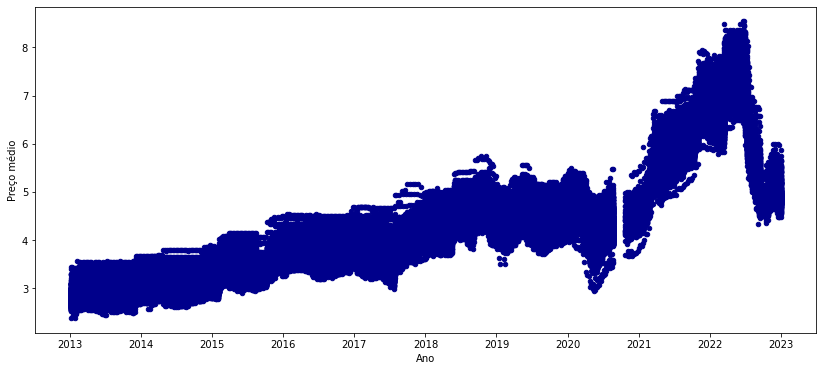

In [ ]:
#Tendência na variação do preço médio da gasolina comum no Brasil
#Dados serão melhor explorados no Looker Studio

filtro_gasolina = df_plot.produto == 'GASOLINA COMUM'
df_gasol = df_plot.loc[filtro_gasolina]

df_gasol.plot.scatter(x ='data_final', y = 'preco_medio_revenda', c = 'DarkBlue', xlabel = 'Ano', ylabel = 'Preço médio', figsize = (14,6))

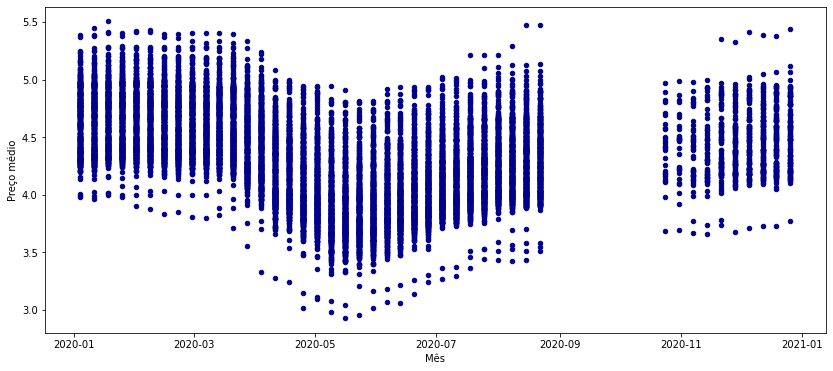

In [ ]:
# Percebeu-se um gap de dados no dataframe no terceiro semestre de 2020

filtro_ano = df_plot.data_final.dt.year == 2020

df_gasol_ano = df_plot.loc[filtro_ano & filtro_gasolina]

df_gasol_ano.plot.scatter(x ='data_final', y = 'preco_medio_revenda', c = 'DarkBlue', xlabel = 'Mês', ylabel = 'Preço médio', figsize = (14,6))

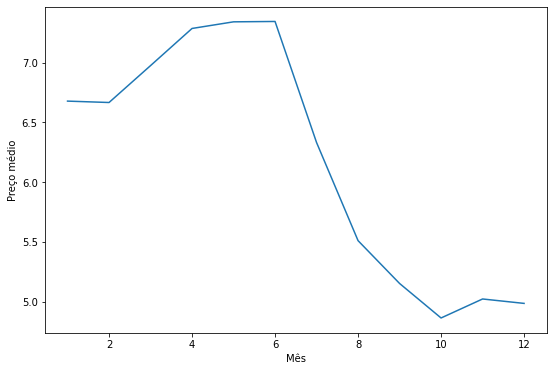

In [ ]:
# Preço médio da gasolina comum no Brasil no ano de 2022

filtro_2022 = df_plot.data_final.dt.year == 2022

df_gasol_2022 = df_plot.loc[filtro_2022 & filtro_gasolina]

df_gasol_2022.groupby(df_gasol_2022.data_final.dt.month)['preco_medio_revenda'].mean().plot.line(xlabel = 'Mês', ylabel = 'Preço médio',figsize = (9,6))

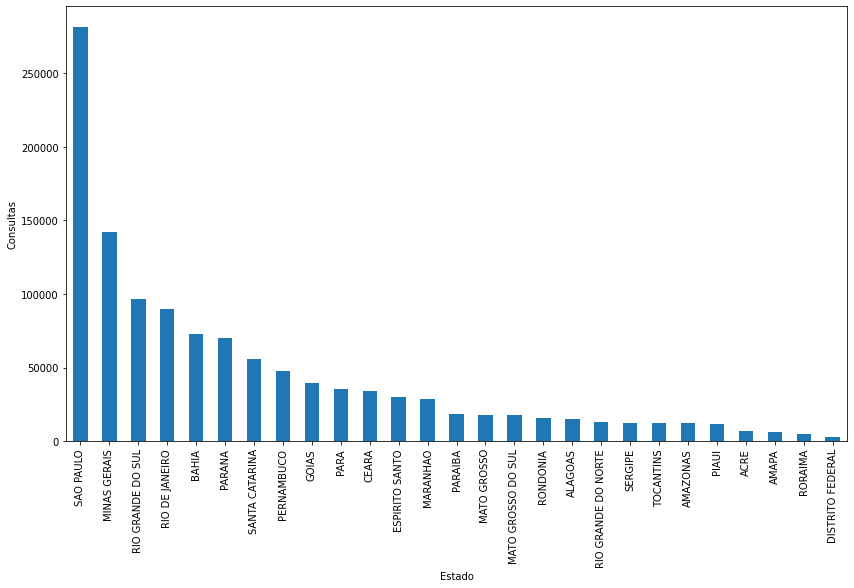

In [ ]:
# Quantidade de municípios consultados por estado (de 2013 a 2022)

df_plot.groupby(['estado']).size().sort_values(ascending = False).plot.bar(xlabel = 'Estado', ylabel = 'Consultas', figsize = (14,8))